In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Estimer le nombre réel de cas avant confinement

### Données hospitalisation par sexe

In [11]:
gender_df = pd.read_csv('../doc/current_gender.csv', sep=';')

gender_df = gender_df.rename(columns={'sexe': 'gender', 'jour': 'day', 'rea': 'icu', 'rad': 'recovered', 'dc': 'death'})

gender_df = gender_df.groupby(['gender', 'day'])['hosp', 'icu', 'recovered', 'death'].agg('sum').reset_index()

gender_df_h = gender_df.loc[gender_df['gender'] == 1, ['day', 'hosp', 'icu', 'recovered', 'death']].reset_index(drop=True)
gender_df_f = gender_df.loc[gender_df['gender'] == 2, ['day', 'hosp', 'icu', 'recovered', 'death']].reset_index(drop=True)

gender_df = pd.merge(gender_df_h, gender_df_f, on='day', how='inner', suffixes=('_h', '_f'))

states = ['hosp', 'icu', 'recovered', 'death']

for state in states:
    gender_df[f'{state}_ph'] = gender_df[f'{state}_h'] / (gender_df[f'{state}_h'] + gender_df[f'{state}_f'])

cols = ['day'] + [f'{state}_ph' for state in states]

gender_df = gender_df.loc[:, cols]

gender_df.head()

,day,hosp_ph,icu_ph,recovered_ph,death_ph
0,2020-03-18,0.574497,0.687173,0.532676,0.557604
1,2020-03-19,0.580247,0.708119,0.507881,0.568254
2,2020-03-20,0.577091,0.714286,0.504218,0.568182
3,2020-03-21,0.578698,0.717407,0.498021,0.575581
4,2020-03-22,0.581164,0.718387,0.497827,0.575121


### Process age
Then we compute the number of current cases by age class:

In [12]:
age_df = pd.read_csv('../doc/current_age.csv', sep=';')

# rename columns
age_df = age_df.rename(columns={'cl_age90': 'age', 'jour': 'day', 'rea': 'icu', 'rad': 'recovered', 'dc': 'death'})

# remove total statistics
age_df = age_df.loc[age_df['age'] != 0]

# map to our age classes
mapping_age = {9: 0, 19: 0, 29: 20, 39: 30, 49: 40, 59: 50, 69: 60, 79: 70, 89: 80, 90: 80}
age_df['age'] = age_df['age'].apply(lambda x: mapping_age.get(x))

# sum groupby
age_df = age_df.groupby(['day', 'age'])['hosp', 'icu', 'recovered', 'death'].agg('sum').reset_index()



age_df.head()

,day,age,hosp,icu,recovered,death
0,2020-03-18,0,40,6,74,0
1,2020-03-18,20,50,9,76,1
2,2020-03-18,30,112,24,89,1
3,2020-03-18,40,201,53,107,5
4,2020-03-18,50,407,132,152,4


## Join age and gender

In [18]:
df = pd.merge(age_df, gender_df, on='day')

for state in states:
    df[f'{state}_h'] = df[f'{state}'] * df[f'{state}_ph']
    df[f'{state}_h'] = df[f'{state}_h'].apply(lambda x: round(x))
    df[f'{state}_f'] = df[f'{state}'] * (1 - df[f'{state}_ph'])
    df[f'{state}_f'] = df[f'{state}_f'].apply(lambda x: round(x))

    
cols_h = [f'{state}_h' for state in states]
cols_f = [f'{state}_f' for state in states]

df_h = df.loc[:, ['age', 'day'] + cols_h]
df_h['gender'] = 'h'
df_h = df_h.rename(columns={f'{state}_h': state for state in states})

df_f = df.loc[:, ['age', 'day'] + cols_f]
df_f['gender'] = 'f'
df_f = df_f.rename(columns={f'{state}_f': state for state in states})

df = df_h.append(df_f, ignore_index=True)

df = df.sort_values(by=['day', 'age', 'gender']).reset_index(drop=True)

df['demography'] = df.apply(lambda x: f"{x['gender']}_{x['age']}", 1)
                                          
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d')
                                          
df.head(20)

,age,day,hosp,icu,recovered,death,gender,demography
0,0,2020-03-18,17,2,35,0,f,f_0
1,0,2020-03-18,23,4,39,0,h,h_0
2,20,2020-03-18,21,3,36,0,f,f_20
3,20,2020-03-18,29,6,40,1,h,h_20
4,30,2020-03-18,48,8,42,0,f,f_30
5,30,2020-03-18,64,16,47,1,h,h_30
6,40,2020-03-18,86,17,50,2,f,f_40
7,40,2020-03-18,115,36,57,3,h,h_40
8,50,2020-03-18,173,41,71,2,f,f_50
9,50,2020-03-18,234,91,81,2,h,h_50


## New hospitalisations by demography
Now we want to estimate the number of new hospitalisation by demography (gender x age group):

In [19]:
shift = 8

In [20]:
new_cases_df = pd.read_csv('../doc/new_overall.csv', sep=';')
new_cases_df = new_cases_df.groupby('jour')['incid_hosp'].agg('sum').reset_index()
new_cases_df = new_cases_df.rename(columns={'jour': 'day', 'incid_hosp': 'new_hosp'})

# Cutting the first n days according to shift

# shifted_new_cases_df = new_cases_df.loc[shift:, ['new_hosp']].reset_index(drop=True)

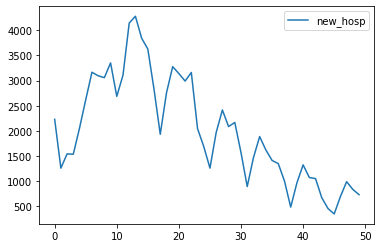

In [21]:
new_cases_df.plot()

Now we compute the proportion for each demography of the daily current hospitalisation:

In [38]:
total_day = df.groupby(['day'])['hosp'].agg('sum').reset_index()
total_day = total_day.rename(columns={'hosp': 'total_hosp'})

proportion_df = pd.merge(df, total_day, on='day', how='left')

proportion_df['prop_hosp'] = proportion_df['hosp'] / proportion_df['total_hosp']

proportion_df.head(20)

,age,day,hosp,icu,recovered,death,gender,demography,total_hosp,prop_hosp
0,0,2020-03-18,17,2,35,0,f,f_0,2905,0.005852
1,0,2020-03-18,23,4,39,0,h,h_0,2905,0.007917
2,20,2020-03-18,21,3,36,0,f,f_20,2905,0.007229
3,20,2020-03-18,29,6,40,1,h,h_20,2905,0.009983
4,30,2020-03-18,48,8,42,0,f,f_30,2905,0.016523
5,30,2020-03-18,64,16,47,1,h,h_30,2905,0.022031
6,40,2020-03-18,86,17,50,2,f,f_40,2905,0.029604
7,40,2020-03-18,115,36,57,3,h,h_40,2905,0.039587
8,50,2020-03-18,173,41,71,2,f,f_50,2905,0.059552
9,50,2020-03-18,234,91,81,2,h,h_50,2905,0.080551


[]

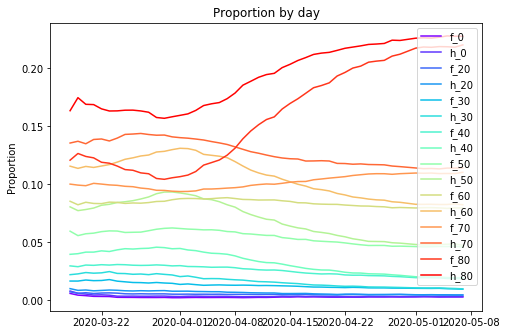

In [37]:
from matplotlib.pyplot import cm

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

colors = cm.rainbow(np.linspace(0, 1, proportion_df['demography'].nunique()))

proportion_df['day'] = pd.to_datetime(proportion_df['day'])
days = proportion_df['day'].unique()

for i, demography in enumerate(proportion_df['demography'].unique()):
    ax.plot(days, proportion_df.loc[proportion_df['demography']==demography]['prop_hosp'], color=colors[i], label=demography)

ax.legend()
ax.set_ylabel('Proportion')
ax.set_title('Proportion by day')
plt.plot()     



    

In [107]:
prop_df = proportion_df.loc[:15, ['demography', 'prop_hosp']]

In [108]:
prop_df

,demography,prop_hosp
0,f_0,0.005852
1,h_0,0.007917
2,f_20,0.007229
3,h_20,0.009983
4,f_30,0.016523
5,h_30,0.022031
6,f_40,0.029604
7,h_40,0.039587
8,f_50,0.059552
9,h_50,0.080551


### Nouveaux cas d'hospitalisation

In [109]:
new_cases_df = pd.read_csv('../doc/new_overall.csv', sep=';')
new_cases_df = new_cases_df.groupby('jour')['incid_hosp'].agg('sum').reset_index()
new_cases_df = new_cases_df.rename(columns={'jour': 'day', 'incid_hosp': 'new_hosp'})

n_demographies = 16

new_cases_df = new_cases_df.loc[shifted_new_cases_df.index.repeat(n_demographies)].reset_index(drop=True)

In [110]:
new_cases_df

,day,new_hosp
0,2020-03-19,2229
1,2020-03-19,2229
2,2020-03-19,2229
3,2020-03-19,2229
4,2020-03-19,2229
5,2020-03-19,2229
6,2020-03-19,2229
7,2020-03-19,2229
8,2020-03-19,2229
9,2020-03-19,2229


In [111]:
prop_df_repeat = None

for _ in range(new_cases_df['day'].nunique()):
    prop_df_repeat = prop_df if prop_df_repeat is None else prop_df_repeat.append(prop_df, ignore_index=True)

In [112]:
new_cases_df = pd.concat([new_cases_df, prop_df_repeat], axis=1)

In [113]:
new_cases_df['new_hosp'] = new_cases_df['new_hosp'] * new_cases_df['prop_hosp']

In [114]:
new_cases_df

,day,new_hosp,demography,prop_hosp
0,2020-03-19,13.044062,f_0,0.005852
1,2020-03-19,17.647849,h_0,0.007917
2,2020-03-19,16.113253,f_20,0.007229
3,2020-03-19,22.251635,h_20,0.009983
4,2020-03-19,36.830293,f_30,0.016523
5,2020-03-19,49.107057,h_30,0.022031
6,2020-03-19,65.987608,f_40,0.029604
7,2020-03-19,88.239243,h_40,0.039587
8,2020-03-19,132.742513,f_50,0.059552
9,2020-03-19,179.547676,h_50,0.080551


Now we load the probability of hospitalisation given infected:

In [115]:
transition_df = pd.read_csv('../data/df_transitions_finale.csv')

# "infected_hosp" is the probability of getting hospitalised given infected
transition_df = transition_df.loc[:, ['demography', 'infected_hosp']]

In [116]:
transition_df

,demography,infected_hosp
0,h_0,0.0010
1,f_0,0.0009
2,h_20,0.0060
3,f_20,0.0050
4,h_30,0.0120
5,f_30,0.0090
6,h_40,0.0160
7,f_40,0.0130
8,h_50,0.0320
9,f_50,0.0250


In [117]:
new_cases_df = pd.merge(new_cases_df, transition_df, on='demography', how='left')

In [118]:
new_cases_df

,day,new_hosp,demography,prop_hosp,infected_hosp
0,2020-03-19,13.044062,f_0,0.005852,0.0009
1,2020-03-19,17.647849,h_0,0.007917,0.0010
2,2020-03-19,16.113253,f_20,0.007229,0.0050
3,2020-03-19,22.251635,h_20,0.009983,0.0060
4,2020-03-19,36.830293,f_30,0.016523,0.0090
5,2020-03-19,49.107057,h_30,0.022031,0.0120
6,2020-03-19,65.987608,f_40,0.029604,0.0130
7,2020-03-19,88.239243,h_40,0.039587,0.0160
8,2020-03-19,132.742513,f_50,0.059552,0.0250
9,2020-03-19,179.547676,h_50,0.080551,0.0320


In [119]:
# infected 7 days before

new_cases_df['infected'] = new_cases_df['new_hosp'] / new_cases_df['infected_hosp']

In [120]:
new_cases_df['asymptomatic'] = 5/6 / (1/10) * new_cases_df['infected']
new_cases_df['asymptomatic'] = new_cases_df['infected'] / (1/10)

In [121]:
new_cases_df['day'] = pd.to_datetime(new_cases_df['day'])
new_cases_df['day_infected'] = new_cases_df['day'] - pd.Timedelta(days=6)
new_cases_df['day_asymptomatic'] = new_cases_df['day'] - pd.Timedelta(days=13)

In [122]:
new_cases_df

,day,new_hosp,demography,prop_hosp,infected_hosp,infected,asymptomatic,day_infected,day_asymptomatic
0,2020-03-19,13.044062,f_0,0.005852,0.0009,14493.402180,144934.021801,2020-03-13,2020-03-06
1,2020-03-19,17.647849,h_0,0.007917,0.0010,17647.848537,176478.485370,2020-03-13,2020-03-06
2,2020-03-19,16.113253,f_20,0.007229,0.0050,3222.650602,32226.506024,2020-03-13,2020-03-06
3,2020-03-19,22.251635,h_20,0.009983,0.0060,3708.605852,37086.058520,2020-03-13,2020-03-06
4,2020-03-19,36.830293,f_30,0.016523,0.0090,4092.254733,40922.547332,2020-03-13,2020-03-06
5,2020-03-19,49.107057,h_30,0.022031,0.0120,4092.254733,40922.547332,2020-03-13,2020-03-06
6,2020-03-19,65.987608,f_40,0.029604,0.0130,5075.969813,50759.698133,2020-03-13,2020-03-06
7,2020-03-19,88.239243,h_40,0.039587,0.0160,5514.952668,55149.526678,2020-03-13,2020-03-06
8,2020-03-19,132.742513,f_50,0.059552,0.0250,5309.700516,53097.005164,2020-03-13,2020-03-06
9,2020-03-19,179.547676,h_50,0.080551,0.0320,5610.864888,56108.648881,2020-03-13,2020-03-06


In [123]:
asymptomatic_df = new_cases_df.loc[:, ['day_asymptomatic', 'asymptomatic', 'demography']]
infected_df = new_cases_df.loc[:, ['day_infected', 'infected', 'demography']]

asymptomatic_df

,day_asymptomatic,asymptomatic,demography
0,2020-03-06,144934.021801,f_0
1,2020-03-06,176478.485370,h_0
2,2020-03-06,32226.506024,f_20
3,2020-03-06,37086.058520,h_20
4,2020-03-06,40922.547332,f_30
5,2020-03-06,40922.547332,h_30
6,2020-03-06,50759.698133,f_40
7,2020-03-06,55149.526678,h_40
8,2020-03-06,53097.005164,f_50
9,2020-03-06,56108.648881,h_50


In [124]:


asymptomatic_df = asymptomatic_df.rename(columns={'day_asymptomatic': 'day'})
infected_df = infected_df.rename(columns={'day_infected': 'day'})

case_df = pd.merge(asymptomatic_df, infected_df, on=['day', 'demography'])

In [125]:
case_df

,day,asymptomatic,demography,infected
0,2020-03-13,201308.089501,f_0,14493.402180
1,2020-03-13,245122.203098,h_0,17647.848537
2,2020-03-13,44761.445783,f_20,3222.650602
3,2020-03-13,51511.187608,h_20,3708.605852
4,2020-03-13,56839.931153,f_30,4092.254733
5,2020-03-13,56839.931153,h_30,4092.254733
6,2020-03-13,70503.376142,f_40,5075.969813
7,2020-03-13,76600.688468,h_40,5514.952668
8,2020-03-13,73749.810671,f_50,5309.700516
9,2020-03-13,77932.874355,h_50,5610.864888


In [127]:
day_case_df = case_df.groupby('day')['asymptomatic', 'infected'].agg('sum').reset_index()

day_case_df

,day,asymptomatic,infected
0,2020-03-13,1.171444e+06,84339.409730
1,2020-03-14,1.157066e+06,47523.687134
2,2020-03-15,1.268307e+06,58269.489001
3,2020-03-16,1.015932e+06,58042.465018
4,2020-03-17,1.175984e+06,77680.039558
5,2020-03-18,1.568357e+06,99058.131302
6,2020-03-19,1.619816e+06,119792.988427
7,2020-03-20,1.454845e+06,117144.375291
8,2020-03-21,1.372360e+06,115706.556731
9,2020-03-22,1.067769e+06,126830.731904


### Estimate the current number of asymptomatic cases by demography

We consider it takes 6 days between the contamination and the appearance of symptoms. This time we consider the probability for getting infected (symptomatic) if getting asymptomatic equals to 0.5 for all demographics.

We proceed the same way:

In [672]:
shift = 6

In [673]:
last_index = df.shape[0] - n_demographies * shift - 1
shifted_df = df.loc[:last_index,:]

In [674]:
shifted_infected = df.loc[shift * n_demographies:, ['infected']].reset_index(drop=True)
shifted_infected = shifted_infected.rename(columns={'infected': 'shifted_infected'})

shifted_df = pd.concat([shifted_df, shifted_infected], axis=1)

In [675]:
shifted_df.head()

,day,demography,infected,hosp,icu,recovered,death,shifted_infected
0,2020-03-18,f_0,11335,17,2,35,0,9392
1,2020-03-18,h_0,13802,23,4,39,0,11835
2,2020-03-18,f_20,2520,21,3,36,0,4125
3,2020-03-18,h_20,2900,29,6,40,1,4847
4,2020-03-18,f_30,3201,48,8,42,0,6199


In [676]:
p_asympinf = .1

In [677]:
shifted_df['asymptomatic'] = shifted_df['shifted_infected'] * (1 / p_asympinf)

In [678]:
cols_to_keep = ['day', 'demography', 'asymptomatic', 'infected', 'hosp', 'icu', 'recovered', 'death']
df = shifted_df.loc[:, cols_to_keep]

In [679]:
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d')

In [680]:
df.to_csv('../data/state_repartion_demography.csv', index=False)

## Comparison with the reported number of cases

In [681]:
estimate_df = df.groupby(['day'])['asymptomatic', 'infected', 'hosp', 'icu', 'recovered', 'death'].agg('sum').reset_index()
estimate_df['estimated_total_cases'] = estimate_df.apply(lambda x: x['asymptomatic'] + x['infected'] + x['hosp'] + x['icu'], 1)



In [682]:
reported_df = pd.read_csv('../doc/owid.csv')


reported_df = reported_df.loc[reported_df['location'] == 'France', ['date', 'total_cases']].reset_index(drop=True)

reported_df = reported_df.rename(columns={'date': 'day', 'total_cases': 'reported_total_cases'})
reported_df['day'] = pd.to_datetime(reported_df['day'])

In [683]:
comparison_df = pd.merge(estimate_df, reported_df, on='day', how='left')

In [684]:
comparison_df_plot = comparison_df.loc[(comparison_df['day'] >= '2020-03-20') & (comparison_df['day'] <= '2020-04-20')]

[]

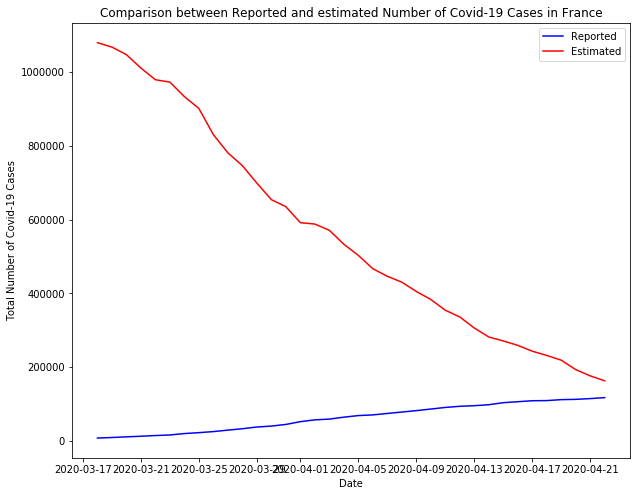

In [685]:
plt.figure(figsize=(10, 8))
plt.plot(comparison_df['day'], comparison_df['reported_total_cases'], 'b-', label = 'Reported')
plt.plot(comparison_df['day'], comparison_df['estimated_total_cases'], 'r-', label = 'Estimated')
plt.xlabel('Date')
plt.ylabel('Total Number of Covid-19 Cases')
plt.title('Comparison between Reported and estimated Number of Covid-19 Cases in France')
plt.legend()
plt.plot()

## Générer les durées courante de par état

In [715]:
repartition_df = pd.read_csv('../data/state_repartion_demography.csv')

repartition_df.head()

,day,demography,asymptomatic,infected,hosp,icu,recovered,death
0,2020-03-18,f_0,93920.0,11335,17,2,35,0
1,2020-03-18,h_0,118350.0,13802,23,4,39,0
2,2020-03-18,f_20,41250.0,2520,21,3,36,0
3,2020-03-18,h_20,48470.0,2900,29,6,40,1
4,2020-03-18,f_30,61990.0,3201,48,8,42,0


In [716]:
import numpy as np
from datetime import datetime

def get_under_params(mean, mediane):
    mu = np.log(mediane)
    sigma = np.sqrt(2 * (np.log(mean) - mu))
    return mu, sigma

def draw_lognormal(mean, mediane, n):
    mu, sigma = get_under_params(mean, mediane)
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

pop_totale = 700000

states =  ['healthy', 'asymptomatic', 'asympcont', 'infected', 'hosp', 'icu', 'death', 'recovercont', 'recovered']
states2ids = {state: i for i, state in enumerate(states)}

In [717]:
state_mm = {'asymptomatic': (6, 5), 'infected': (9, 7), 'hosp': (10, 4), 'icu': (18, 17), 'recovercont': (14, 12)}
day = datetime(2020, 4, 1)

In [719]:
df['day'] = pd.to_datetime(df['day'])

day_df = repartition_df.loc[repartition_df['day'] == date].reset_index(drop=True)

day_df

,day,demography,asymptomatic,infected,hosp,icu,recovered,death
0,2020-04-01,f_0,46380.0,5985,52,7,150,0
1,2020-04-01,h_0,57850.0,7976,77,22,157,1
2,2020-04-01,f_20,17530.0,2590,125,13,328,2
3,2020-04-01,h_20,20280.0,3246,188,38,344,2
4,2020-04-01,f_30,25440.0,3798,330,50,566,6
5,2020-04-01,h_30,26490.0,4256,493,145,596,9
6,2020-04-01,f_40,38720.0,5753,722,126,775,17
7,2020-04-01,h_40,43680.0,6999,1081,366,815,28
8,2020-04-01,f_50,41790.0,6207,1498,333,1010,64
9,2020-04-01,h_50,45380.0,7254,2241,972,1062,104


In [720]:
demography_state_duration = {}

for _, row in day_df.iterrows():
    current_state_ids, current_state_durations = np.array([]), np.array([])
    demography = row['demography']
    for state in states:
        if state not in row:
            continue
        state_id = states2ids.get(state)
        n_state = int(row[state] * pop_totale / 67000000)
        current_state_ids = np.append(current_state_ids, np.ones(n_state) * state_id)
        if state in ['recovered', 'death']:
            state_durations = np.ones(n_state) * -1
            current_state_durations = np.append(current_state_durations, state_durations)
            continue            
        mean, mediane = state_mm.get(state)
        state_durations = draw_lognormal(mean, mediane, n_state)
        current_state_durations = np.append(current_state_durations, state_durations)
    current_state_durations = np.around(current_state_durations).astype(np.uint32)
    demography_state_duration[demography] = {'state_ids': current_state_ids, 'state_durations': current_state_durations}
    

demography_state_duration        
        

{'f_0': {'state_ids': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [698]:
draw_lognormal(3, 2, 10)

array([1.90655208, 0.45541264, 1.09350718, 3.36979702, 0.88818941,
       0.87602648, 0.79930989, 0.58666902, 1.21855785, 0.43025799])

In [703]:
states2ids

{'healthy': 0,
 'asymptomatic': 1,
 'asympcont': 2,
 'infected': 3,
 'hosp': 4,
 'icu': 5,
 'death': 6,
 'recovercont': 7,
 'recovered': 8}

In [714]:
demography_state_duration['h_50']['state_durations'].shape[0]

594

In [ ]:
imperial_df = pd.read_csv('../doc/estimates-imperial-college.csv')

imperial_df = imperial_df.loc[imperial_df['country'] == 'France', ['time', 'predicted_infections_mean_cumulative']].reset_index(drop=True)

imperial_df['time'] = pd.to_datetime(imperial_df['time'])
imperial_df.set_index('time', inplace=True)

imperial_df.plot()
plt.show()

NameError: name 'pd' is not defined

[]

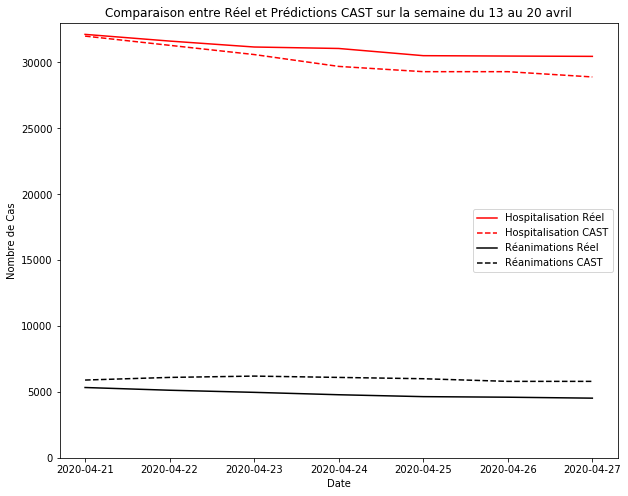

In [12]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from numpy import array

day = datetime(2020, 4, 21)
days = [day + timedelta(i) for i in range(7)]

hosp_real = array([32131, 31623, 31172, 31061, 30515, 30486, 30462])
hosp_cast = array([32000, 31300, 30600, 29700, 29300, 29300, 28900])
array([6599, 6331, 6139, 5922, 5733, 5644, 5584])
rea_cast = array([5900, 6100, 6200, 6100, 6000, 5800, 5800])


plt.figure(figsize=(10, 8))
plt.plot(days, hosp_real, 'r-', label = 'Hospitalisation Réel')
plt.plot(days, hosp_cast, 'r--', label = 'Hospitalisation CAST')
plt.plot(days, rea_real, 'k-', label = 'Réanimations Réel')
plt.plot(days, rea_cast, 'k--', label = 'Réanimations CAST')
plt.xlabel('Date')
plt.ylabel('Nombre de Cas')

plt.ylim([0, 33000])
plt.title('Comparaison entre Réel et Prédictions CAST sur la semaine du 13 au 20 avril')
plt.legend()
plt.plot()

In [19]:
import numpy as np

params = np.load('../calibrations/0.npy')

In [20]:
params

array({'score': {'hosp': {'err': 4.71641158527172, 'real': array([29984, 29627, 29113, 28554, 28119, 28114, 27954, 27607, 26736,
       26192, 25809, 25751, 25739, 25472, 24701, 23912, 23139]), 'estimated': array([30100, 29700, 29600, 29100, 28600, 28400, 28100, 28000, 27800,
       27400, 27400, 27300, 27200, 27100, 27100, 27000, 26800])}, 'icu': {'err': 4.4232304613611095, 'real': array([5334, 5127, 4967, 4785, 4641, 4598, 4526, 4392, 4128, 3947, 3819,
       3770, 3762, 3639, 3375, 3095, 2911]), 'estimated': array([5100, 5000, 4800, 4800, 4800, 4600, 4600, 4600, 4300, 4300, 4200,
       4100, 3700, 3600, 3500, 3300, 3200])}}, 'params': {'cell_ids': array([     0,      1,      2, ..., 328178, 328179, 328180], dtype=uint32), 'attractivities': array([ 0.        ,  0.        ,  0.        , ..., -0.01029916,
        0.3830058 , -0.09146073]), 'unsafeties': array([1.        , 1.        , 1.        , ..., 0.35659619, 0.20569509,
       0.21822717]), 'xcoords': array([63.59267488, 61.770695

In [50]:
csi_path = '../propagsim/np/maps/week1/current_state_ids.npy'
csd_path = '../propagsim/np/maps/week1/current_state_durations.npy'

current_state_ids = np.load(csi_path).flatten()
current_state_durations = np.load(csd_path).flatten()

In [56]:
current_state_ids[current_state_ids==5].shape[0]

30

In [57]:
pos_icu = np.where(current_state_ids==5)[0]

In [58]:
switch = pos_icu[:43]

In [59]:
current_state_ids[switch] = 8
current_state_durations[switch] = -1

In [60]:
current_state_ids[current_state_ids==5].shape[0]

27

In [61]:
np.save(csi_path, current_state_ids)
np.save(csd_path, current_state_durations)

=========================

In [133]:
res_same = {0: {0: 696371, 1: 1314, 2: 28, 3: 157, 4: 222, 5: 27, 6: 130, 7: 45, 8: 773},
 1: {0: 696364, 1: 1313, 2: 29, 3: 156, 4: 221, 5: 25, 6: 130, 7: 46, 8: 783},
 2: {0: 696359, 1: 1311, 2: 29, 3: 155, 4: 221, 5: 24, 6: 131, 7: 44, 8: 793},
 3: {0: 696357, 1: 1310, 2: 30, 3: 155, 4: 221, 5: 23, 6: 131, 7: 31, 8: 809},
 4: {0: 696356, 1: 1303, 2: 31, 3: 155, 4: 221, 5: 23, 6: 131, 7: 26, 8: 821},
 5: {0: 696355, 1: 1298, 2: 32, 3: 155, 4: 221, 5: 23, 6: 131, 7: 26, 8: 826},
 6: {0: 696354, 1: 1297, 2: 32, 3: 155, 4: 220, 5: 21, 6: 131, 7: 23, 8: 834},
 7: {0: 696349, 1: 1301, 2: 32, 3: 155, 4: 220, 5: 21, 6: 131, 7: 18, 8: 840},
 8: {0: 696347, 1: 1296, 2: 32, 3: 154, 4: 220, 5: 19, 6: 132, 7: 19, 8: 848},
 9: {0: 696345, 1: 1295, 2: 32, 3: 154, 4: 220, 5: 19, 6: 132, 7: 19, 8: 851},
 10: {0: 696339, 1: 1298, 2: 32, 3: 154, 4: 220, 5: 18, 6: 132, 7: 15, 8: 859},
 11: {0: 696334, 1: 1298, 2: 33, 3: 154, 4: 220, 5: 16, 6: 132, 7: 15, 8: 865},
 12: {0: 696334, 1: 1296, 2: 34, 3: 154, 4: 220, 5: 16, 6: 132, 7: 12, 8: 869},
 13: {0: 696334, 1: 1291, 2: 35, 3: 154, 4: 220, 5: 16, 6: 132, 7: 9, 8: 876},
 14: {0: 696332, 1: 1288, 2: 35, 3: 154, 4: 220, 5: 15, 6: 132, 7: 13, 8: 878},
 15: {0: 696330, 1: 1288, 2: 35, 3: 154, 4: 220, 5: 15, 6: 132, 7: 13, 8: 880},
 16: {0: 696328, 1: 1289, 2: 35, 3: 154, 4: 220, 5: 15, 6: 132, 7: 11, 8: 883},
 17: {0: 696326, 1: 1286, 2: 36, 3: 154, 4: 220, 5: 15, 6: 132, 7: 9, 8: 889},
 18: {0: 696324, 1: 1285, 2: 37, 3: 154, 4: 220, 5: 15, 6: 132, 7: 9, 8: 891},
 19: {0: 696321, 1: 1287, 2: 37, 3: 154, 4: 220, 5: 15, 6: 132, 7: 6, 8: 895}}

In [134]:
n_hosps, n_icus = [], []
for k, v in res_same.items():
    n_hosp, n_icu = v[4], v[5]
    n_hosps.append(n_hosp)
    n_icus.append(n_icu)
    

In [135]:
n_hosps, n_icus = np.array(n_hosps), np.array(n_icus)

In [136]:
n_icus = 100 * n_icus
n_hosps = 100 * n_hosps

In [139]:
n_hosps

array([22200, 22100, 22100, 22100, 22100, 22100, 22000, 22000, 22000,
       22000, 22000, 22000, 22000, 22000, 22000, 22000, 22000, 22000,
       22000, 22000])

In [137]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from numpy import array

day = datetime(2020, 5, 11)
days = [day + timedelta(i) for i in range(20)]

[]

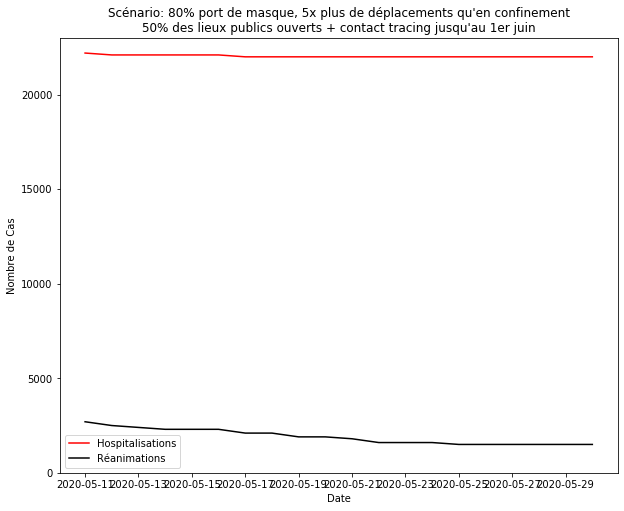

In [140]:
plt.figure(figsize=(10, 8))
plt.plot(days, n_hosps, 'r-', label = 'Hospitalisations')
plt.plot(days, n_icus, 'k-', label = 'Réanimations')
plt.xlabel('Date')
plt.ylabel('Nombre de Cas')

plt.ylim([0, 23000])
plt.title("Scénario: 80% port de masque, 5x plus de déplacements qu'en confinement\n50% des lieux publics ouverts + contact tracing jusqu'au 1er juin")
plt.legend()
plt.plot()